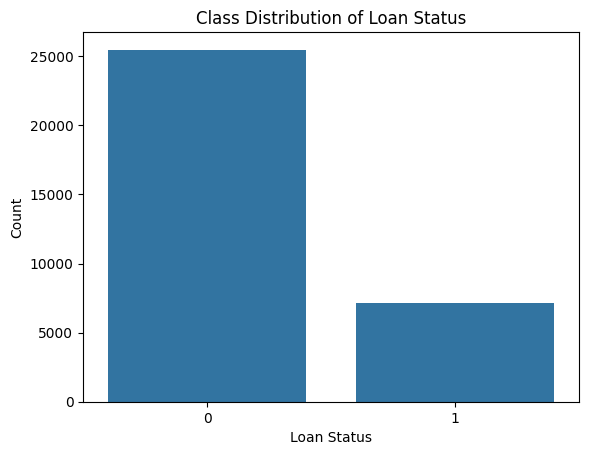

Time-Series Split Evaluation:
Fold 1: Accuracy = 0.884, AUC = 0.874
Fold 2: Accuracy = 0.876, AUC = 0.871
Fold 3: Accuracy = 0.845, AUC = 0.904


C:\Users\Dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Fold 4: Accuracy = 0.656, AUC = nan


C:\Users\Dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Fold 5: Accuracy = 0.751, AUC = nan


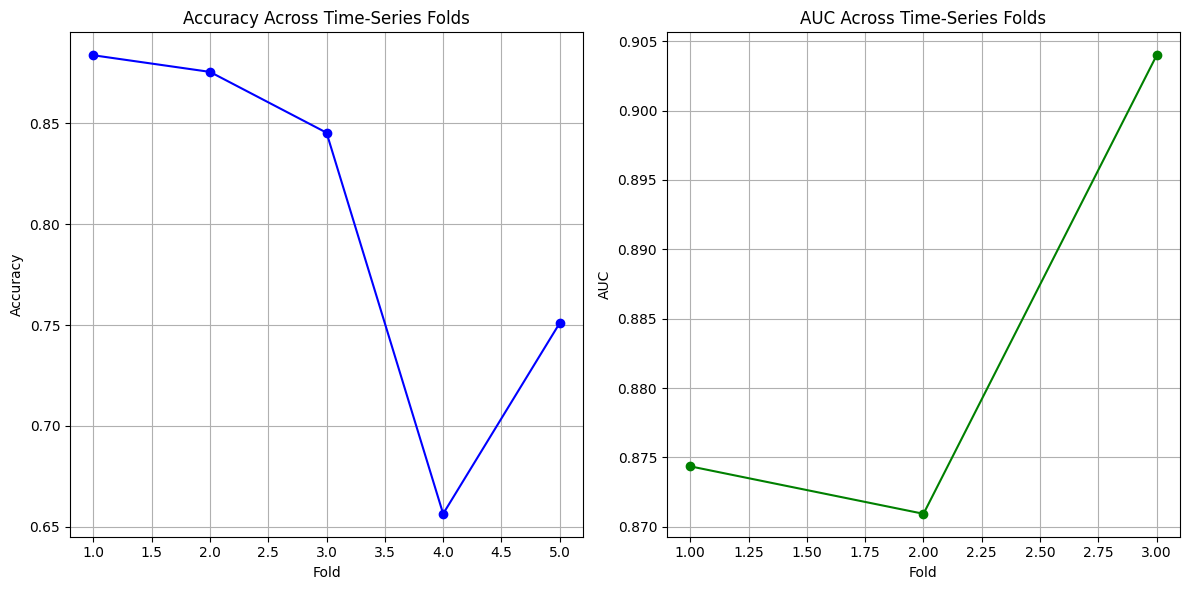

<Figure size 1000x600 with 0 Axes>

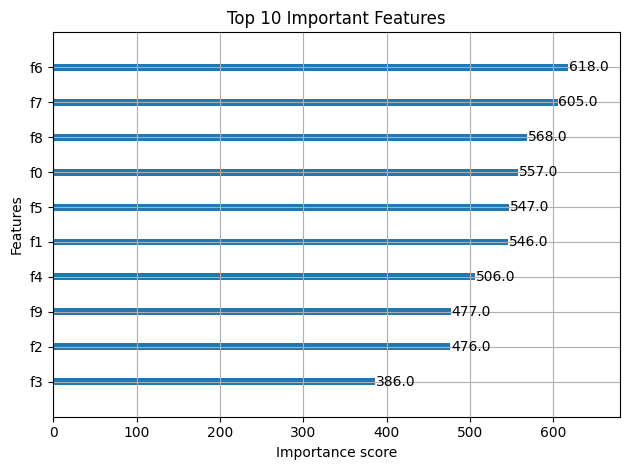

Model saved as xgboost_model_credit_risk_smote.pkl


In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  # Ensure numpy is imported
import pickle

# Load the dataset
file_path = "C:/Users/Dell/Desktop/credit_risk_dataset.csv"
data = pd.read_csv(file_path)

# Check and plot the distribution of the 'loan_status' target variable
sns.countplot(x='loan_status', data=data)
plt.title('Class Distribution of Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.show()

# Preprocess the dataset
# Convert categorical columns into numerical representations
data['person_home_ownership'] = data['person_home_ownership'].map({'RENT': 0, 'OWN': 1, 'MORTGAGE': 2})
data['loan_intent'] = data['loan_intent'].map({'PERSONAL': 0, 'EDUCATION': 1, 'MEDICAL': 2})
data['loan_grade'] = data['loan_grade'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3})
data['cb_person_default_on_file'] = data['cb_person_default_on_file'].map({'N': 0, 'Y': 1})

# Feature engineering
# Create new feature: income per age
data['income_per_age'] = data['person_income'] / (data['person_age'] + 1)

# Apply log transformation to skewed features (e.g., income, loan amount)
data['log_person_income'] = data['person_income'].apply(lambda x: np.log(x + 1))  # Adding 1 to avoid log(0)
data['log_loan_amnt'] = data['loan_amnt'].apply(lambda x: np.log(x + 1))  # Adding 1 to avoid log(0)

# Interaction feature between income and loan amount
data['income_loan_interaction'] = data['person_income'] * data['loan_amnt']

# Define features (X) and target (y)
X = data.drop(columns=['loan_status'])
y = data['loan_status']

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Apply PCA for dimensionality reduction (optional)
pca = PCA(n_components=10)  # Reduce to 10 components to avoid overfitting
X_scaled = pca.fit_transform(X_scaled)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Time-series cross-validation setup
tscv = TimeSeriesSplit(n_splits=5)

# Variables to store performance metrics
accuracy_scores = []
auc_scores = []

# Time-Series Cross Validation and Model Evaluation with GPU Utilization using XGBoost
print("Time-Series Split Evaluation:")
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_resampled)):
    X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
    y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]
    
    # Create DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    # Set XGBoost parameters with GPU usage
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'tree_method': 'hist',  # Use GPU acceleration (tree_method='gpu_hist' for GPU)
        'device': 'cuda',  # Enable GPU
        'learning_rate': 0.1,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
    }
    
    # Train the model
    clf = xgb.train(params, dtrain, num_boost_round=100)
    
    # Predict and evaluate
    preds = clf.predict(dtest)
    probas = preds
    acc = accuracy_score(y_test, (probas > 0.5).astype(int))
    auc = roc_auc_score(y_test, probas)
    
    accuracy_scores.append(acc)
    auc_scores.append(auc)
    
    print(f"Fold {fold+1}: Accuracy = {acc:.3f}, AUC = {auc:.3f}")

# ---- Plotting Accuracy and AUC Scores ----
plt.figure(figsize=(12, 6))

# Plot accuracy scores
plt.subplot(1, 2, 1)
plt.plot(range(1, len(accuracy_scores) + 1), accuracy_scores, marker='o', color='blue', label='Accuracy')
plt.title('Accuracy Across Time-Series Folds')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.grid(True)

# Plot AUC scores
plt.subplot(1, 2, 2)
plt.plot(range(1, len(auc_scores) + 1), auc_scores, marker='o', color='green', label='AUC')
plt.title('AUC Across Time-Series Folds')
plt.xlabel('Fold')
plt.ylabel('AUC')
plt.grid(True)

plt.tight_layout()
plt.show()

# ---- Plot Feature Importance ----
plt.figure(figsize=(10, 6))
xgb.plot_importance(clf, max_num_features=10, importance_type='weight', title='Top 10 Important Features')
plt.tight_layout()
plt.show()

# Save the trained model
model_filename = 'xgboost_model_credit_risk_smote.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(clf, f)

print(f"Model saved as {model_filename}")


In [2]:
# Count the occurrences of each class in the 'loan_status' column
loan_status_counts = data['loan_status'].value_counts()

# Print the count of loan status 1 and 0
print("Loan Status Count:")
print(loan_status_counts)


Loan Status Count:
loan_status
0    25473
1     7108
Name: count, dtype: int64
